# COMP5318 - Machine Learning and Data Mining: Assignment 2
<div style="text-align: right"> Group 86 </div>
<div style="text-align: right"> tlin4302 | 470322974 | Jenny Tsai-chen Lin </div>
<div style="text-align: right"> COde | ID | Name </div>
<div style="text-align: right"> COde | ID | Name </div>

## The notebook includes sections :

    Section 1. Library and general functions 
    Section 2. Data descriptive summary and pre-processing
    Section 3. Implement algorithms
        3.1 A
        3.2 B
        3.3 C
    Section 4. Compare result between algorithms in train dataset 
    Section 5: Best perfroming algorithms in testing data  (we will submit this in seperate notebook as well)
    Section 6. Hardware and software specifications

In response to 4 main parts of report requirement: 

    1. Try 3 different Machine Learning methods and compare their performance. | Section 3 & Section 4
    2. Choosing an appropriate model and its complexity | Section 3
    3. Using pre-processing techniques on the datasets | Section 2
    4. Computer infrastructure   | TBC
    5. Ease of prototyping
    6. Hardware and software specifications of the computer that you used for performance evaluation | Section 5

## Section 1. Library and general functions 

In [1]:
#package loaded
#pip install PySimpleGUI
#pip install pyperclip
#pip install chess
#pip install python-chess

#  Go to anaconda prompt to install package imblearn
# anaconda: conda install -c glemaitre imbalanced-learn
#pip install kmeans-smote

from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PySimpleGUI as sg 
import pyperclip
import chess

import time 

start_time = time.time()
#main()
print('--- {} seconds ---'.format(time.time() - start_time))

C:\Users\JL\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


--- 0.0 seconds ---


### global variables

In [2]:
# define global variable 
#g_dataset_dir = "../dataset/" # when OS system is used
g_dataset_dir = "./dataset/"   # when window system is used
g_train_dir = g_dataset_dir + "/train/"
g_test_dir = g_dataset_dir + "/test/"

g_image_size = 400

g_grid_row = 8
g_grid_col = 8

g_grid_num = g_grid_row * g_grid_col
g_grid_size = int(g_image_size / g_grid_row)


#Processing 1 - scale down 
g_down_sampled_size = 200
g_down_sampled_grid_size = int(g_grid_size / (g_image_size / g_down_sampled_size))

# global instance of mapping of char vs chess pieces
# reference: Forsyth–Edwards Notation, https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation
# 
# pawn = "P", knight = "N", bishop = "B", rook = "R", queen = "Q" and king = "K"
# White pieces are designated using upper-case letters ("PNBRQK") while black pieces use lowercase ("pnbrqk")
# we use 0 to note an empty grid.
# 13 items in total.

g_piece_mapping = {
    "P" : "pawn",
    "N" : "knight",
    "B" : "bishop",
    "R" : "rook",
    "Q" : "queen",
    "K" : "king",

    "p" : "pawn",
    "n" : "knight",
    "b" : "bishop",
    "r" : "rook",
    "q" : "queen",
    "k" : "king",

    "0" : "empty_grid"
}

g_num_labels = len(g_piece_mapping)

a_random_file = "./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg"

### Helper codes for label & board

In [3]:
#DataHelper.py

import os

import cv2
from skimage import io
import numpy as np

import glob
import h5py

# get clean name by a path, where in our case this gets the FEN conviniently
def GetCleanNameByPath(file_name):
    return os.path.splitext(os.path.basename(file_name))[0]

# get full paths to the files in a directory.
def GetFileNamesInDir(path_name, extension="*", num_return = 0):
    if num_return == 0:
        return glob.glob(path_name + "/*." + extension)
    else:
        return glob.glob(path_name + "/*." + extension)[:num_return]

# get name list
def GetCleanNamesInDir(path_name, extension = "*", num_return = 0):
    names = GetFileNamesInDir(path_name, extension)
    offset = len(extension) + 1
    clean_names = [os.path.basename(x)[:-offset] for x in names]
    if num_return == 0:
        return clean_names
    else:
        return clean_names[:num_return]

# read dataset
def ReadImages(file_names, path = "", format = cv2.IMREAD_COLOR):
    if path == "":
        return [cv2.imread(f, format) for f in file_names]
    else:
        return [cv2.imread(path + "/" + f, format) for f in file_names]

# read image by name
def ReadImage(file_name):
    return io.imread(file_name)


# h5py functions
    
# read h5py file
# we assume the labels and 
def ReadH5pyFile(file_name, data_name):
    h5_buffer = h5py.File(file_name)
    return h5_buffer[data_name].copy()

# write h5py file
def WriteH5pyFile(file_name, mat, data_name = "dataset"):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset(data_name, data = mat)

In [4]:
#BoardHelper.py  

import re
import string
from collections import OrderedDict 

import numpy as np
import skimage.util
from skimage.util.shape import view_as_blocks


# from ChessGlobalDefs import * - global definitions

#FEN TO LABELS OF SQUARES
def FENtoL(fen): 
    rules = {
        r"-": r"",
        r"1": r"0",
        r"2": r"00",
        r"3": r"000",
        r"4": r"0000",
        r"5": r"00000",
        r"6": r"000000",
        r"7": r"0000000",
        r"8": r"00000000",
    }

    for key in rules.keys():
        fen = re.sub(key, rules[key], fen)

    return list(fen)


# Label array to char list:
def LabelArrayToL(arr):
    rules = {
        0 : "P",
        1 : "N",
        2 : "B",
        3 : "R",
        4 : "Q",
        5 : "K",

        6 : "p",
        7 : "n",
        8 : "b",
        9 : "r",
       10 : "q",
       11 : "k",

       12 : "0"
    }

    flattened = arr.flatten(order = "C")

    L = []

    for x in flattened:
        L.append(rules[x])

    return L

# char list to FEN
def LtoFEN(L):

    FEN = ""
    
    for y in range(8):
        counter = 0
        for x in range(8):
            idx = x + y * 8
            char = L[idx]

            if char == "0":
                counter += 1
                if x == 7:
                    FEN += str(counter)
            else:
                if counter:
                    FEN += str(counter)
                    counter = 0

                FEN += char
        if y != 7:
            FEN += "-"
        
            
    return FEN



# FEN to one-hot encoding, in our case, it returns an 64 by 13 array, with each row as a one-hot to a grid.
def FENtoOneHot(fen):

    # this rule is in the same format as g_piece_mapping
    #rules = {
    #    "P" : np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "N" : np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "B" : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "R" : np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "Q" : np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "K" : np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    #                    
    #    "p" : np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
    #    "n" : np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
    #    "b" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
    #    "r" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
    #    "q" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
    #    "k" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    #                    
    #    "0" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    #}
    rules = {
        "P" : 0,
        "N" : 1,
        "B" : 2,
        "R" : 3,
        "Q" : 4,
        "K" : 5,

        "p" : 6,
        "n" : 7,
        "b" : 8,
        "r" : 9,
        "q" : 10,
        "k" : 11,

        "0" : 12
    }

    L = FENtoL(fen)
    one_hot_array = np.zeros((g_grid_num, g_num_labels), dtype = np.int32) # 64 by 13
    for i, c in enumerate(L):
        one_hot_array[i, rules[c]] = 1

    return one_hot_array

# get 8*8 char matrix
def LtoCharMat(l):
    if type(l) == list:
        return np.array(l).reshape((8,8))
    if type(l) == str:
        return np.array([l]).reshape((8,8))

def GetBoardCell(board_image, row = 0, col = 0, size = 50):
    return np.array(board_image)[row*size:(row+1)*size,col*size:(col+1)*size]

# get grids of image (64 squuare)
def ImageToGrids(image, grid_size_x, grid_size_y):
    return skimage.util.shape.view_as_blocks(image, block_shape = (grid_size_y, grid_size_x, 3)).squeeze(axis = 2)

#### Confusion matrix - heatmap

In [5]:
from sklearn.metrics import confusion_matrix


import pandas as pd

# function - to create confusion matrix
def conf_mat(true,pred):
    A = pd.Series(true, name='Actual')
    P = pd.Series(pred, name='Predict')
    #conf_matt  = pd.crosstab(A, P, margins=True)
    conf_matt  = pd.crosstab(A, P)
    return conf_matt


#function - to create heatmap for confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matt, cmap=plt.cm.gray_r): 
    conf_norm = conf_matt / conf_matt.sum(axis=1)  
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_norm, cmap=cmap)
    fig.colorbar(cax)
    tick_marks = np.arange(len(conf_norm.columns))
    plt.xticks(tick_marks, conf_norm.columns)
    plt.yticks(tick_marks, conf_norm.index)
    plt.ylabel(conf_norm.index.name)
    plt.xlabel(conf_norm.columns.name)

## Section 2. Data descriptive summary and pre-processing

### Pre-processing - generic

In [6]:
# split into 64 small square from 1 board
# image resized to 400x 400 to 200x 200. 64 square at 25x 25 each

def PreprocessImage(image):
    image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
    # 1st and 2nd dim is 8
    grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

    # debug
    #plt.imshow(grids[0][5])
    #plt.show()

    return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)


# split into 64 small square from 1 board
def func_generator(train_file_names):
    for image_file_name in train_file_names:
        img = ReadImage(image_file_name)
        x = PreprocessImage(img)
        y = np.array(FENtoOneHot(GetCleanNameByPath(image_file_name)))
    return x, y

### Pre-processing  - to dataframe

In [7]:
# modified function 

def PreprocessImage_df(image):
        image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
        # 1st and 2nd dim is 8
        grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)
        g = grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)
        df =pd.DataFrame()
        for i in range(8):
            for j in range(8):
                df = df.append(pd.Series(g[i][j].reshape(75)), ignore_index=True)
        return df
    
# modifed function 

def func_generator_df(train_file_names):
    df =pd.DataFrame()
    for image_file_name in train_file_names:
        img = ReadImage(image_file_name) 
        x = PreprocessImage_df(img) # 64 x 75 dataframe
        y = np.array(FENtoL(GetCleanNameByPath(image_file_name)))
        x['y'] = y
        df = df.append(x, ignore_index=True)
    return df

### Pre-processing  - w SIFT to dataframe

In [8]:
# Processing image with sift

g_sift_extractor = sift = cv2.xfeatures2d.SIFT_create(edgeThreshold = 0)

def ExtractSIFTForGrid(board_image, row, col, center_x = 25, center_y = 25, radius = 45):
    kps = [cv2.KeyPoint(x = center_x + 50 * col, y = center_y + 50 * row, _size = 45)]
    keypoints, descriptors = g_sift_extractor.compute(image = board_image, keypoints = kps)
    return keypoints[0], descriptors[0, :]


def PreprocessImage_sift(image):
    image = cv2.Canny(image,100,200)

    # debug
    #print('canny image')
    #plt.imshow(image)
    #plt.show()
    
    
    
    df =pd.DataFrame()
    for i in range(8):
        for j in range(8):
            kp, desc = ExtractSIFTForGrid(image,i,j)
            df = df.append(pd.Series(desc), ignore_index=True)
            
    return df

# split into 64 small square from 1 board
def func_generator_sift(train_file_names):
    df =pd.DataFrame()
    for image_file_name in train_file_names:
        img = ReadImage(image_file_name)
        x = PreprocessImage_sift(img)
        y = np.array(FENtoL(GetCleanNameByPath(image_file_name)))
        x['y'] = y
        df = df.append(x, ignore_index=True)
    return df


### Example of SIFT

file name: ./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg


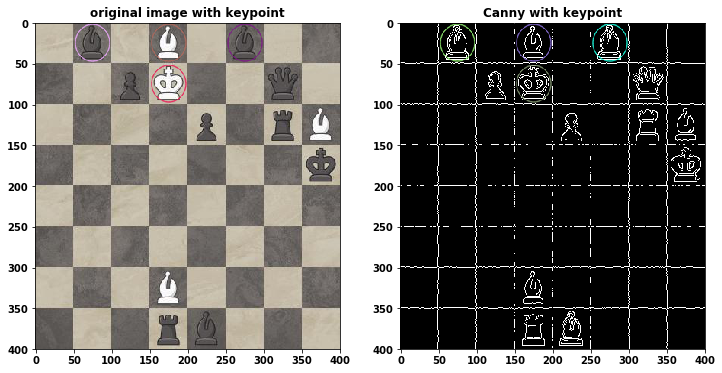

SIFT OUTPUT for Canny at squares


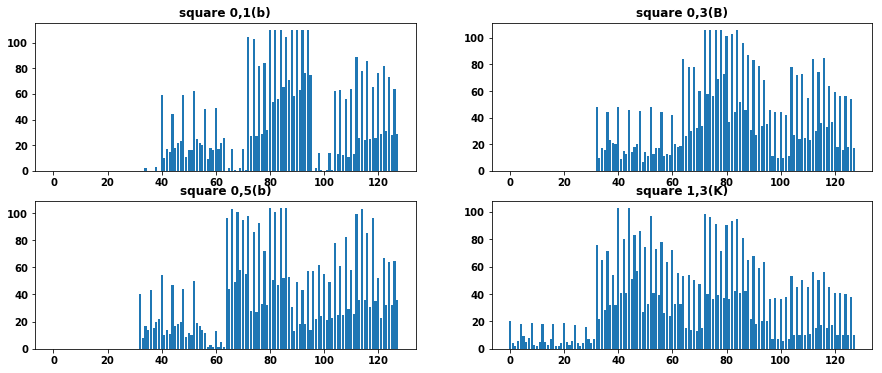

In [9]:
# Illustration of 
import cv2
#print("Sift: decriptor size:", cv2.SIFT_create().descriptorSize())
img = ReadImage(a_random_file)

img1 = cv2.Canny(img,100,200)

kp, desc = ExtractSIFTForGrid(img1, 0, 1)
kp2, desc2 = ExtractSIFTForGrid(img1, 0, 3)
kp3, desc3 = ExtractSIFTForGrid(img1, 0, 5)
kp4, desc4 = ExtractSIFTForGrid(img1, 1, 3)
img_kp = cv2.drawKeypoints(img, [kp, kp2,kp3,kp4], img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp1 = cv2.drawKeypoints(img1, [kp, kp2,kp3,kp4], img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print('file name:',a_random_file)


f = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(img_kp, aspect='auto')
plt.title('original image with keypoint')

plt.subplot(1, 2, 2)
plt.imshow(img_kp1, aspect='auto')
plt.title('Canny with keypoint')
plt.show()

print('SIFT OUTPUT for Canny at squares')
plt.figure(figsize=(15,6))
#plt.tight_layout()
plt.subplot(2, 2, 1)
plt.title('square 0,1(b)')
plt.bar(x = range(128), height = desc)
plt.xticks(x = range(128))

plt.subplot(2,2, 2)
plt.title('square 0,3(B)')
plt.bar(x = range(128), height = desc2)
plt.xticks(x = range(128))

plt.subplot(2,2,3)
plt.title('square 0,5(b)')
plt.bar(x = range(128), height = desc3)
plt.xticks(x = range(128))


plt.subplot(2,2,4)
plt.title('square 1,3(K)')
plt.bar(x = range(128), height = desc4)
plt.xticks(x = range(128))
plt.show()



start_time = time.time()
num_train = 1000
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)
df_sift= func_generator_sift(train_file_names)
X = df_sift.drop('y', axis=1)
Y = df_sift['y']
#main()
print('--- {} seconds ---'.format(time.time() - start_time))

In [ ]:
# FENtoL to weight image quality


from sklearn.model_selection import train_test_split

num_train = 80000
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)
ys = []
for image_file_name in train_file_names:
    y = FENtoL(GetCleanNameByPath(image_file_name))
    ys.extend(y)


df =pd.DataFrame(np.array(ys).reshape(num_train,64))
df.head()
df['w'] = (df != '0').astype(int).sum(axis=1)
df['FEN']=train_file_names
df.sort_values(by='w', ascending=False).head()

# disregard image with less than 10 chess

df_selected = df[df['w']>=10]
df_selected = df_selected['FEN'].values.tolist()
len(df_selected)

start_time = time.time()

train_file_names = df_selected
df_sift= func_generator_sift(train_file_names)
X = df_sift.drop('y', axis=1)
Y = df_sift['y']
#main()
print('--- {} seconds ---'.format(time.time() - start_time))


In [ ]:
df_sift.head()

### Split train and validation dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.33, random_state=0)

### Balancing classes (undersampling)

In [ ]:
# ref from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
#https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py


import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# if experience ImportError: cannot import name '_UnstableArchMixin' from 'sklearn.base' refer below for trouble shoot.
#https://stackoverflow.com/questions/55447538/importerror-cannot-import-name-unstablearchmixin-from-sklearn-base/55448307

[print('Class {} has {} instances'.format(label, count))
 for label, count in zip(*np.unique(Y_train, return_counts=True))]
print()

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, Y_resampled = rus.fit_resample(X_train, Y_train)

[print('Class {} has {} instances after undersampling'.format(label, count))
 for label, count in zip(*np.unique(Y_resampled, return_counts=True))]

## Section 3. Implement algorithms

### Section 3.1 Implement algorithms - A

### Section 3.2 Implement algorithms - B

### Section 3.3 Implement algorithms - C

### Logistic Regression - GridSearchCV

In [ ]:
# modified from COMP 5310 Principle of DS in 2019
# Tuning parameters 
#import warnings
#warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Perform grid search
#param_grid = [{'solver': ['newton-cg', 'lbfgs', 'sag','saga'], 'C': [0.001,0.01,0.1,1]}] # different solver doesn't not yield differnet result
param_grid = [{'C': [0.001,0.01]}]
logreg = GridSearchCV(LogisticRegression(penalty = 'l2', random_state=0,max_iter = 500), param_grid)
logreg.fit(X_train, Y_train)


In [ ]:
# Print grid search results
from sklearn.metrics import classification_report

means = logreg.cv_results_['mean_test_score']
stds = logreg.cv_results_['std_test_score']
params = logreg.cv_results_['params']

print('Grid search mean and stdev:\n')

for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, param))


# Print best params
print('\nBest parameters:', logreg.best_params_)


print("Detailed classification report:")
print()
print(classification_report(Y_val, logreg.predict(X_val)))
print()

In [ ]:
# create heat matt
logreg_mat= conf_mat(Y_val, logreg.predict(X_val))
plot_confusion_matrix(logreg_mat) 

### Decision Tree - GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Perform grid search
param_grid = [
    {'max_depth': [2, 3, 4, 5, 6],
     'criterion': ['entropy', 'gini'],
     'splitter': ['best', 'random']}
]
tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
tree.fit(X_train, Y_train)

In [ ]:
# Print grid search results

means = tree.cv_results_['mean_test_score']
stds = tree.cv_results_['std_test_score']
params = tree.cv_results_['params']

print('Grid search mean and stdev:\n')

for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, param))


# Print best params
print('\nBest parameters:', tree.best_params_)


print("Detailed classification report:")
print()
print(classification_report(Y_val, tree.predict(X_val)))
print()



In [ ]:
# create heat matt
tree_mat= conf_mat(Y_val, tree.predict(X_val))
plot_confusion_matrix(tree_mat) 

### Knn -  GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

# Perform grid search
param_grid = [
    {'n_neighbors': [13],
     'weights': ['uniform', 'distance'],
     'metric': ['euclidean', 'manhattan','minkowski']}
]
knn = GridSearchCV(KNeighborsClassifier(), param_grid)
knn.fit(X_train, Y_train)

# Print grid search results
from sklearn.metrics import classification_report

means = knn.cv_results_['mean_test_score']
stds = knn.cv_results_['std_test_score']
params = knn.cv_results_['params']

print('Grid search mean and stdev:\n')

for mean, std, p in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, p))


# Print best params
print('\nBest parameters:', knn.best_params_)


print("Detailed classification report:")
print()
print(classification_report(Y_val, knn.predict(X_val)))
print()


# create heat matt
knn_mat= conf_mat(Y_val, knn.predict(X_val))
plot_confusion_matrix(knn_mat) 

## 10 fold validation (use cross_val_score)

#https://scikit-learn.org/stable/modules/cross_validation.html


Example: 
>>> X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.4, random_state=0)

>>> X_train.shape, y_train.shape
((90, 4), (90,))
>>> X_test.shape, y_test.shape
((60, 4), (60,))

>>> clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
>>> clf.score(X_test, y_test)
0.96...



    
>>> from sklearn.model_selection import cross_val_score
>>> clf = svm.SVC(kernel='linear', C=1)
>>> scores = cross_val_score(clf, X, y, cv=5)
>>> scores
array([0.96..., 1.  ..., 0.96..., 0.96..., 1.        ])    
    

### Test Accuracy (WIP)

In [ ]:
# this should accept a 64 * m * n numpy array as query data, and returns the fen notation of the board.
#def Predict(self, query_data):
#    grids = CNNClassifier.PreprocessImage(query_data)
#    pred = self.__model__.predict(grids).argmax(axis=1)

#    return pred

In [ ]:
#def TestAccuracy(self, test_file_names):
#    num_files = len(test_file_names)

#    predict_result = self.__model__.predict(CNNClassifier.func_generator(test_file_names)).argmax(axis=1)
#    predict_result = predict_result.reshape(num_files, -1)
#    predicted_fen_arr = np.array([BoardHelper.LtoFEN(BoardHelper.LabelArrayToL(labels)) for labels in predict_result])
#    test_fens = np.array([DataHelper.GetCleanNameByPath(file_name) for file_name in test_file_names])

#    final_accuracy = (predicted_fen_arr == test_fens).astype(np.float).mean()
#    return final_accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression


def testAccuracy_l(test_file_names, model):
    df = func_generator_sift(test_file_names)
    Predict_act = func_generator_sift(test_file_names)['y']
    X_test = df.drop('y', axis=1)
    
    #model fit
    
    #Generate predict
    a = logreg.predict(X_test) 
print('\nPredicted type of first five organisms from test split:', logreg.predict(X_test)[:5])
print('Actual type of first five organisms from test split:', Y_test[:5])

### AdaBoostClassifier

In [ ]:
###https://machinelearningmastery.com/adaboost-ensemble-in-python/

from sklearn.ensemble import AdaBoostClassifier

param_grid = [{"n_estimators":[100,200,300],
              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0]
             }]
abc = GridSearchCV(AdaBoostClassifier(n_estimators=100, random_state=0), param_grid)
abc.fit(X_train, Y_train)

In [ ]:
# Print grid search results
from sklearn.metrics import classification_report

means = knn.cv_results_['mean_test_score']
stds = knn.cv_results_['std_test_score']
params = knn.cv_results_['params']

print('Grid search mean and stdev:\n')

for mean, std, p in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, p))


# Print best params
print('\nBest parameters:', knn.best_params_)


print("Detailed classification report:")
print()
print(classification_report(Y_val, abc.predict(X_val)))
print()


### weight training data

In [ ]:
# FENtoL to weight image quality

df =pd.DataFrame(np.array(ys).reshape(num_train,64))
df.head()
df['w'] = (df != '0').astype(int).sum(axis=1)
df['FEN']=train_file_names
df.sort_values(by='w', ascending=False).head()

# disregard image with less than 10 chess

df_selected = df[df['w']>=10]
df_selected = df_selected['FEN'].values.tolist()
len(df_selected)

start_time = time.time()

train_file_names = df_selected
df_sift= func_generator_sift(train_file_names)
X = df_sift.drop('y', axis=1)
Y = df_sift['y']
#main()
print('--- {} seconds ---'.format(time.time() - start_time))


In [ ]:
start_time = time.time()

train_file_names = df_selected
df_sift= func_generator_sift(train_file_names)
X = df_sift.drop('y', axis=1)
Y = df_sift['y']
#main()
print('--- {} seconds ---'.format(time.time() - start_time))

In [73]:
from sklearn.model_selection import train_test_split

num_train = 80000
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)
ys = []
for image_file_name in train_file_names:
    y = FENtoL(GetCleanNameByPath(image_file_name))
    ys.extend(y)
    